# Plan


Задача: Бинарная классификация срезов (есть опухоль/нет опухоли)

0. Load sample data
1. Setup VGG-like architecture
2. Simple DataLoader
3. Patch sampling & data augmentation
4. Batch training
5. Tensorboard

# 0. Load sample data

In [1]:
import nibabel
from pathlib import Path
from dpipe.im.visualize import slice3d

In [2]:
data_folder = Path('/home/anvar/work/data/MICCAI_BraTS2020_TrainingData/')

In [3]:
for subdir in data_folder.glob('*'):
    file = subdir.stem
    img = nibabel.load(subdir / f'{file}_flair.nii.gz').get_fdata()
    mask = nibabel.load(subdir / f'{file}_seg.nii.gz').get_fdata()
    break

In [4]:
img.shape, mask.shape

((240, 240, 155), (240, 240, 155))

In [5]:
slice3d(img, mask)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=154), Output()), _dom…

# 1. Setup VGG-like architecture

More examples https://github.com/bentrevett/pytorch-image-classification/

![title](https://camo.githubusercontent.com/fed0475719a58ed51683e32c5fc4157051d1ba44/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f7667672e706e673f7261773d31)

In [6]:
import torch
import torch.nn as nn
from torch.nn import Sequential

`nn.Module` https://pytorch.org/docs/stable/generated/torch.nn.Module.html это базовый класс для определения архитектуры нейронной сети. От него следует наследовать любой класс определяющий нейронную сеть.

In [7]:
class VGGNet(nn.Module):
    def __init__(self):
        super().__init__() # super(VGGNet, self).__init__()
        pass
    
    def forward(self, x):
        return x

net = VGGNet()

`nn.Sequential` https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html это аналог `sklearn.pipeline.Pipeline` это функция, которая последовательно исполняет все функции переданные ей на вход:

```
g = Sequential(a, b, c)
g(x) эквивалентно c(b(a(x)))
```

In [8]:
def conv3x3(in_channels, out_channels, stride=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1)),
        nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True)
    ]

class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = Sequential(
            *conv3x3(1, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 32),
            *conv3x3(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 64),
            *conv3x3(64, 64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(5)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

net = VGGNet()

In [9]:
# Распаковка аргументов

a = [1, 2, 3]
b = [*a, 4, 5, 6]
c = [a, 4, 5, 6]

print(b)
print(c)

[1, 2, 3, 4, 5, 6]
[[1, 2, 3], 4, 5, 6]


In [10]:
rand_tensor = torch.rand((1, 1, 120, 120))

# Кол-во наблюдений x Кол-во каналов x Кол-во пикселей X x Кол-во пикселей Y

In [11]:
net.forward(rand_tensor)

tensor([[-0.0705]], grad_fn=<AddmmBackward>)

# 2. DataLoader

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get `i`

In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
class BraTSDataset(Dataset):
    
    def __init__(self, source_folder: [str, Path], transform=None):
        if isinstance(source_folder, str):
            source_folder = Path(source_folder)
            
        self.images = sorted(list(source_folder.glob('*')))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        
        file_name = self.images[i].stem
        image = nibabel.load(self.images[i] / f'{file_name}_flair.nii.gz').get_fdata()
        mask = nibabel.load(self.images[i] / f'{file_name}_seg.nii.gz').get_fdata()
        sample = image, mask
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [14]:
data_folder = Path('/home/anvar/work/data/MICCAI_BraTS2020_TrainingData/')
dataset = BraTSDataset(data_folder)

In [15]:
img, mask = dataset.__getitem__(40)

In [16]:
img.shape, mask.shape

((240, 240, 155), (240, 240, 155))

# 3. Patch sampling & data augmentation

In [17]:
from torchvision import transforms
import numpy as np

In [18]:
def random_slice(sample):
    image, mask = sample
    nonzero = np.nonzero(np.sum(image, (0, 1)))[0]
    np.random.shuffle(nonzero)
    k = nonzero[0]
    return image[..., k], mask[..., k]

def random_crop(sample):
    
    image, mask = sample
    delta_h, delta_w = 20, 20
    h, w = image.shape
    new_h, new_w = 120, 120
    top = np.random.randint(0, h - delta_h - new_h)
    left = np.random.randint(0, w - delta_w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]
    
    mask = mask[top: top + new_h,
                  left: left + new_w]
    
    return image, np.sum(mask).astype(bool)

def to_tensor(sample):
    image, target = sample
    image = image.reshape(1, image.shape[0], image.shape[1])
    return torch.from_numpy(image), target

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

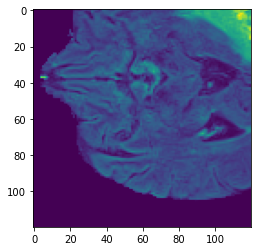

In [20]:
_img, _mask = random_slice([img, mask])
_img, y = random_crop([_img, _mask])

plt.imshow(_img);

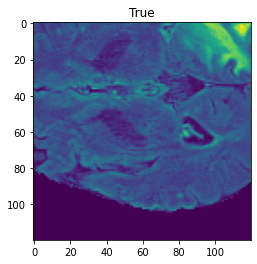

In [21]:
data_transform = transforms.Compose([
                    random_slice,
                    random_crop,
                    to_tensor
            ])

_img, y = data_transform([img, mask])
plt.imshow(_img[0])
plt.title(y);

In [22]:
brats_dataset = BraTSDataset(data_folder, transform=data_transform)

In [23]:
dataset_loader = torch.utils.data.DataLoader(brats_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=8)

In [24]:
for [imgs, ys] in dataset_loader:
    break

In [25]:
imgs.shape

torch.Size([8, 1, 120, 120])


# 4. Batch training (training loop)

# 5. Tensorboard